In [289]:
%matplotlib inline
import matplotlib.pyplot as plt
import plotting
import pickle
from nest import raster_plot
import numpy as np
import os
from scipy.signal import argrelextrema
import pylab
from importlib import reload # reload modules
reload(plotting)
# import warnings
# warnings.filterwarnings('ignore')

<module 'plotting' from '/home/adrossel/Magic/pickle/plotting.py'>

In [2]:
def files(path):  
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield file
def files_start_with(start, path='.'):
    list_of_files = []
    for file in files(path):  
        if file.startswith(start):
            list_of_files.append(file)
    return sorted(list_of_files)
def parse_filename(file):
    return file.replace('.p','').split('_')

In [3]:
from jupyterthemes import jtplot
jtplot.style()
jtplot.style('default')

In [4]:
# Templating for latex code with Jinja2
from jinja2 import Template

In [139]:
# formatted latex string for figures
latex_header = r"""
    \documentclass[a4paper,12pt]{article}

    \usepackage[english]{babel}
    \usepackage{graphicx}
    \usepackage{subcaption}
    \usepackage{rotating}
    \usepackage{pdflscape}
    
    \usepackage{siunitx}

    \begin{document}
"""
latex_footer = r"\end{document}"
figure_template = Template(
    r"""
    \begin{figure}
    \centering
        \includegraphics[width={{ width }}\textwidth]{ {{figure}} }
        \caption{ {{ caption }} }
    \end{figure}
    """)
figure_landscape_template = Template(
    r"""
    \begin{landscape}
    \begin{figure}
        \includegraphics[width=\textwidth]{ {{figure}} }
        \caption{ {{ caption }} }
    \end{figure}
    \end{landscape}
    """)
double_figure_latex_template = Template(
    r"""
\begin{figure}
    \centering
    \begin{subfigure}[b]{0.49\textwidth}
        \includegraphics[width=\textwidth]{ {{fig1}} }
        \caption{ {{cap1}} }
        \label{fig:gull}
    \end{subfigure}
    \begin{subfigure}[b]{0.49\textwidth}
        \includegraphics[width=\textwidth]{ {{fig2}} }
        \caption{ {{cap2}} }
        \label{fig:tiger}
    \end{subfigure}
    \caption{ {{cap_main}} }
    \label{fig:animals}
\end{figure}
    """)
six_figure_latex_template = Template(
    r"""
\begin{figure}
    \begin{subfigure}[b]{0.49\textwidth}
        \includegraphics[width=\textwidth]{ {{fig1}} }
        \caption{ {{cap1}} }
    \end{subfigure}
    \begin{subfigure}[b]{0.49\textwidth}
        \includegraphics[width=\textwidth]{ {{fig2}} }
        \caption{ {{cap2}} }
    \end{subfigure}
    \begin{subfigure}[b]{0.49\textwidth}
        \includegraphics[width=\textwidth]{ {{fig3}} }
        \caption{ {{cap3}} }
    \end{subfigure}
    \begin{subfigure}[b]{0.49\textwidth}
        \includegraphics[width=\textwidth]{ {{fig4}} }
        \caption{ {{cap4}} }
    \end{subfigure}
    \begin{subfigure}[b]{0.49\textwidth}
        \includegraphics[width=\textwidth]{ {{fig5}} }
        \caption{ {{cap5}} }
    \end{subfigure}
    \begin{subfigure}[b]{0.49\textwidth}
        \includegraphics[width=\textwidth]{ {{fig6}} }
        \caption{ {{cap6}} }
    \end{subfigure}
    \caption{ {{cap_main}} }
\end{figure}
    """)

In [281]:
dfs = [(df_ex, df_in), (df_ex2, df_in2), (df_ex3, df_in3), (df_ex4, df_in4)]
# dfs = [(df_ex, df_in)]
len(dfs)

4

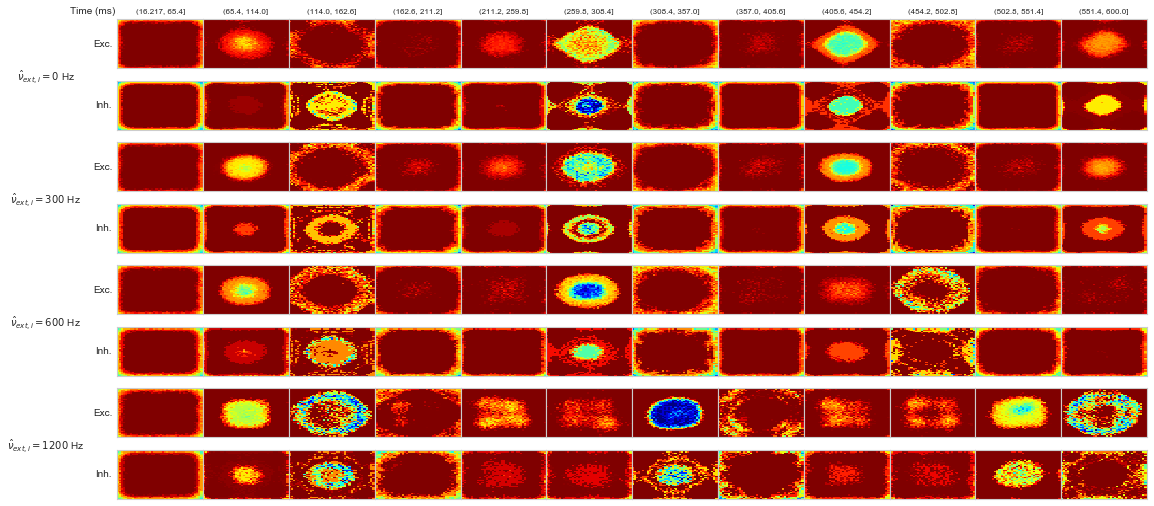

In [282]:
f = visualisation_monster(dfs, nuis=[0., 3., 6., 12.])
path_visu_monster = folders[0]+'/visu_monster.pdf'
plt.savefig(path_visu_monster)

In [273]:
visu_latex_string = figure_landscape_template.render(figure=path_visu_monster,
                             caption='Test')

In [235]:
def create_figure_grid(size):
    import matplotlib.gridspec as gridspec
    fig = plt.figure(figsize=(20,13))
    gs0 = gridspec.GridSpec(12, 1)
    grid = []
    for i in range(size):
        g0 = gridspec.GridSpecFromSubplotSpec(1, 12, subplot_spec=gs0[2*i], wspace=0.0, hspace=0.0)
        g1 = gridspec.GridSpecFromSubplotSpec(1, 12, subplot_spec=gs0[2*i+1], wspace=0.0, hspace=0.0)
        grid.append([g0,g1])
    return fig, grid

In [279]:
def visualisation_helper(df, g0, print_title=False, nui=3.):
    """
    params: print_title: Boolean, if True print time as title above plots from
                            exc population
    """
    ax1 = []
    ax2 = []
#     for i in range(4):
#         for j in range(3):
#             ax1.append(plt.subplot(g0[0][i,j]))
#             ax2.append(plt.subplot(g0[1][i,j]))
    for j in range(12):
        ax1.append(plt.subplot(g0[0][j]))
        ax2.append(plt.subplot(g0[1][j]))
    df_ex_time_cut = df[0].groupby(pd.cut(df[0]['Time'], 12))
    df_in_time_cut = df[1].groupby(pd.cut(df[1]['Time'], 12))
    q = 0
    for df_now, ax in zip(df_ex_time_cut, ax1):
        x = [i[0] for i in df_now[1]['Position']]
        y = [i[1] for i in df_now[1]['Position']]
        if print_title:
            if q == 0:
                ax.text(-0.77, 0.65, r'Time (ms)', va="center", ha="center")
            ax.set_title(df_now[0], fontdict={'fontsize': 8})
        if q == 0:
            ax.text(-1.3, -0.65, r'$\hat{\nu}_{ext, i}=%.0f$ Hz' % (nui*100., ) , va="center", ha="center")
            ax.text(-0.65, 0., r'Exc.', va="center", ha="center")
        h, x, y, q = ax.hist2d(x, y, bins=40, cmap=plt.cm.jet, normed=True, vmin=0., vmax=1.)
        q.set_edgecolor('face')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
    q = 0
    for df_now, ax in zip(df_in_time_cut, ax2):
        if q == 0:
            ax.text(-0.65, 0., r'Inh.', va="center", ha="center")
        x = [i[0] for i in df_now[1]['Position']]
        y = [i[1] for i in df_now[1]['Position']]
        h, x, y, q = ax.hist2d(x, y, bins=40, cmap=plt.cm.jet, normed=True, vmin=0., vmax=1.)
        q.set_edgecolor('face')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
    return q

In [249]:
def visualisation_monster(dfs, title=None, nuis=[]):
    import matplotlib.gridspec as gridspec
    fig, grid = create_figure_grid(len(dfs))
    plt.subplots_adjust(top=0.9, hspace=0.25, right=0.84)
    q = 0
    for df, g0, nui in zip(dfs, grid, nuis):
        if q == 0:
            q = visualisation_helper(df, g0, print_title=True, nui = nui)
        else:
            q = visualisation_helper(df, g0, nui = nui)
#     cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#     fig.colorbar(q, cax=cbar_ax, )
#     fig.text(0.5, 0.08, 'X', ha='center')
#     fig.text(0.48, 0.92, 'Excitatory Neurons', ha='center')
#     fig.text(0.48, 0.5, 'Inhibitory Neurons', ha='center')
#     fig.text(0.08, 0.5, 'Y', va='center', rotation='vertical')
    return fig 

In [246]:
df_ex = pickle.load(open(folders[1]+'/df_ex.pickle', 'rb'))
df_in = pickle.load(open(folders[1]+'/df_in.pickle', 'rb'))
df_ex2 = pickle.load(open(folders[2]+'/df_ex.pickle', 'rb'))
df_in2 = pickle.load(open(folders[2]+'/df_in.pickle', 'rb'))
df_ex3 = pickle.load(open(folders[3]+'/df_ex.pickle', 'rb'))
df_in3 = pickle.load(open(folders[3]+'/df_in.pickle', 'rb'))
df_ex4 = pickle.load(open(folders[4]+'/df_ex.pickle', 'rb'))
df_in4 = pickle.load(open(folders[4]+'/df_in.pickle', 'rb'))
import pandas as pd

In [227]:
parse_filename(folders[3])[-1]

'06'

In [11]:
def dynamics_and_raster_plot(folder, save=True, latex=False):
    state_folder = ''
    params = pickle.load(open(folder+'/parameter.pickle', 'rb'))
    df_ex = pickle.load(open(folder+'/df_ex.pickle', 'rb'))
    df_in = pickle.load(open(folder+'/df_in.pickle', 'rb'))
    fig = plotting.visualisation_both(df_ex, df_in)
    if save: 
        fig_path_visu = folder+'_visu.pdf'
        fig.savefig(fig_path_visu, format='pdf')
    df_ex_data = np.array(df_ex[['Sender', 'Time']].values.tolist())
    df_ex_data = np.array([[n_id, time] for n_id,time in df_ex_data if n_id < 1602 and
                          n_id > 2])
    raster = raster_plot.from_data(df_ex_data, title=r'Excitatory Population', rasterized=True)
    if save: 
        fig_path_raster_exc = folder+state_folder+'_exc_raster.pdf'       
        plt.savefig(fig_path_raster_exc, format='pdf', bbox_inches = "tight")
    plt.show()
    plotting.autocorr(df_ex)
    if save:
        fig_path_autocorr_exc = folder+state_folder+'_exc_autocorr.pdf'       
        plt.savefig(fig_path_autocorr_exc, format='pdf')
    plt.show()
    periods = plotting.period(df_in)
    var = plotting.variance(df_in)
    df_in_data = np.array(df_in[['Sender', 'Time']].values.tolist())
    df_in_data = np.array([[n_id, time] for n_id,time in df_in_data if n_id > 25602 and
                        n_id < 27202])
    raster = raster_plot.from_data(df_in_data, title=r'Inhibitory Population', rasterized=True)
    if save: 
        fig_path_raster_inh = folder+state_folder+'_inh_raster.pdf'       
        plt.savefig(fig_path_raster_inh, format='pdf', bbox_inches = "tight")
    plt.show()
    plotting.autocorr(df_in)
    if save:
        fig_path_autocorr_inh = folder+state_folder+'_inh_autocorr.pdf'       
        plt.savefig(fig_path_autocorr_inh, format='pdf')
    # Cross correlations:
    x = np.unique([x for x,y in df_ex['Position'].values])
    y = np.unique([y for x,y in df_ex['Position'].values])
    tmp1 = df_ex[df_ex['Position'] == (x[5], y[20])]
    tmp2 = df_ex[df_ex['Position'] == (x[20], y[20])]
    tmp3 = df_ex[df_ex['Position'] == (x[35], y[20])]
    tmp4 = df_in[df_in['Position'] == (x[20], y[20])]
    fig_cross_correlation_position, ax = plotting.crossCorrPosition(tmp1, tmp2, tmp3)
    fig_cross_correlation_population, ax = plotting.crossCorrPopulation(tmp3, tmp4)
    if save:
        fig_path_cross_correlation_position = folder+state_folder+'_exc_cross_corr_pos.pdf'       
        fig_cross_correlation_position.savefig(fig_path_cross_correlation_position, format='pdf')
        fig_path_cross_correlation_population = folder+state_folder+'_exc_cross_corr_pop.pdf'       
        fig_cross_correlation_population.savefig(fig_path_cross_correlation_population, format='pdf')
    if latex:
        global visu_latex_string
        visu_latex_string += figure_template.render(figure=fig_path_visu,
                             caption=r"""
                             Time resolution for excitatory and inhibitorypopulation with 
                             $\nu_{exc,ext} = %.2f \,\si{Hz}$ and $\nu_{inh,ext} = %.2f \,\si{Hz}$.
                             """ % (params['Background rate excitatory'],
                                   params['Background rate inhibitory'], ),
                             width=1.0)
        global raster_autocorr_latex_string
        raster_autocorr_latex_string += six_figure_latex_template.render(
            fig1=fig_path_raster_exc,
            cap1="Raster Plot of exc. population",
            fig2=fig_path_raster_inh,
            cap2="Raster Plot of inh. population",
            fig3=fig_path_autocorr_exc,
            cap3="Autocorrelation of exc. population",
            fig4=fig_path_autocorr_inh,
            cap4="Autocorrelation of inh. populatio",
            fig5=fig_path_cross_correlation_position,
            cap5="Cross correlation of exc. population at different $x$-positions.",
            fig6=fig_path_cross_correlation_population,
            cap6="Cross correlation of exc. and inh. neuron at the same position",
            cap_main=r"""Plots for average firing rate of 
                $\nu_{exc,ext} = %.2f \,\si{Hz}$ and $\nu_{inh,ext} = %.2f \,\si{Hz}$.
                """ % (params['Background rate excitatory'],
                        params['Background rate inhibitory'], ),
            width=1.0)

In [12]:
base_folder = 'phase_plane_analysis/new_small'
folders = [f[0] for f in os.walk(base_folder)]
folders.sort()
folders

['phase_plane_analysis/new_small',
 'phase_plane_analysis/new_small/e0_15_i0_00',
 'phase_plane_analysis/new_small/e0_15_i0_03',
 'phase_plane_analysis/new_small/e0_15_i0_06',
 'phase_plane_analysis/new_small/e0_15_i0_09',
 'phase_plane_analysis/new_small/e0_15_i0_12',
 'phase_plane_analysis/new_small/e0_15_i0_15',
 'phase_plane_analysis/new_small/e0_15_i0_21',
 'phase_plane_analysis/new_small/periodicity',
 'phase_plane_analysis/new_small/periodicity/e0_150_i0_000',
 'phase_plane_analysis/new_small/periodicity/e0_150_i0_005',
 'phase_plane_analysis/new_small/periodicity/e0_150_i0_010',
 'phase_plane_analysis/new_small/periodicity/e0_150_i0_015',
 'phase_plane_analysis/new_small/periodicity/e0_150_i0_020',
 'phase_plane_analysis/new_small/periodicity/e0_150_i0_025',
 'phase_plane_analysis/new_small/periodicity/e0_150_i0_030',
 'phase_plane_analysis/new_small/periodicity/e0_150_i0_035',
 'phase_plane_analysis/new_small/periodicity/e0_150_i0_040',
 'phase_plane_analysis/new_small/periodi

In [13]:
with open(base_folder+'/parameter.p', 'rb') as f:
    params = pickle.load(f)
plotting.printParams(folders[0])

Name : tsodyks
Columns : 40
Rows : 40
Radius excitational : 0.2
Sigma excitational : 0.1
Radius inhibitory : 0.2
Sigma inhibitory : 0.1
Jee : 3.0
Jii : 1.0
Jei : 3.0
Jie : -12.0
Background weight : 30.0
Jee Connectivity : 0.4
Jii Connectivity : 0.4
Jei Connectivity : 0.4
Jie Connectivity : 0.4
Number excitational cells : 16
Number inhibitory cells : 4
Weight Stimulus : 0.0
Radius stimulus : 0.1
Sigma Stimulus : 0.05
e2e delay : 1.0
e2i delay : 1.0
i2e delay : 1.0
i2i delay : 1.0
delay growth multiplier : 2
Stimulus rate : 40000.0
Background rate excitatory : 2500.0
Background rate inhibitory : 1500.0
Time before stimulation : 300.0
Time of stimulation : 0.0
Time after Stimulation : 300.0


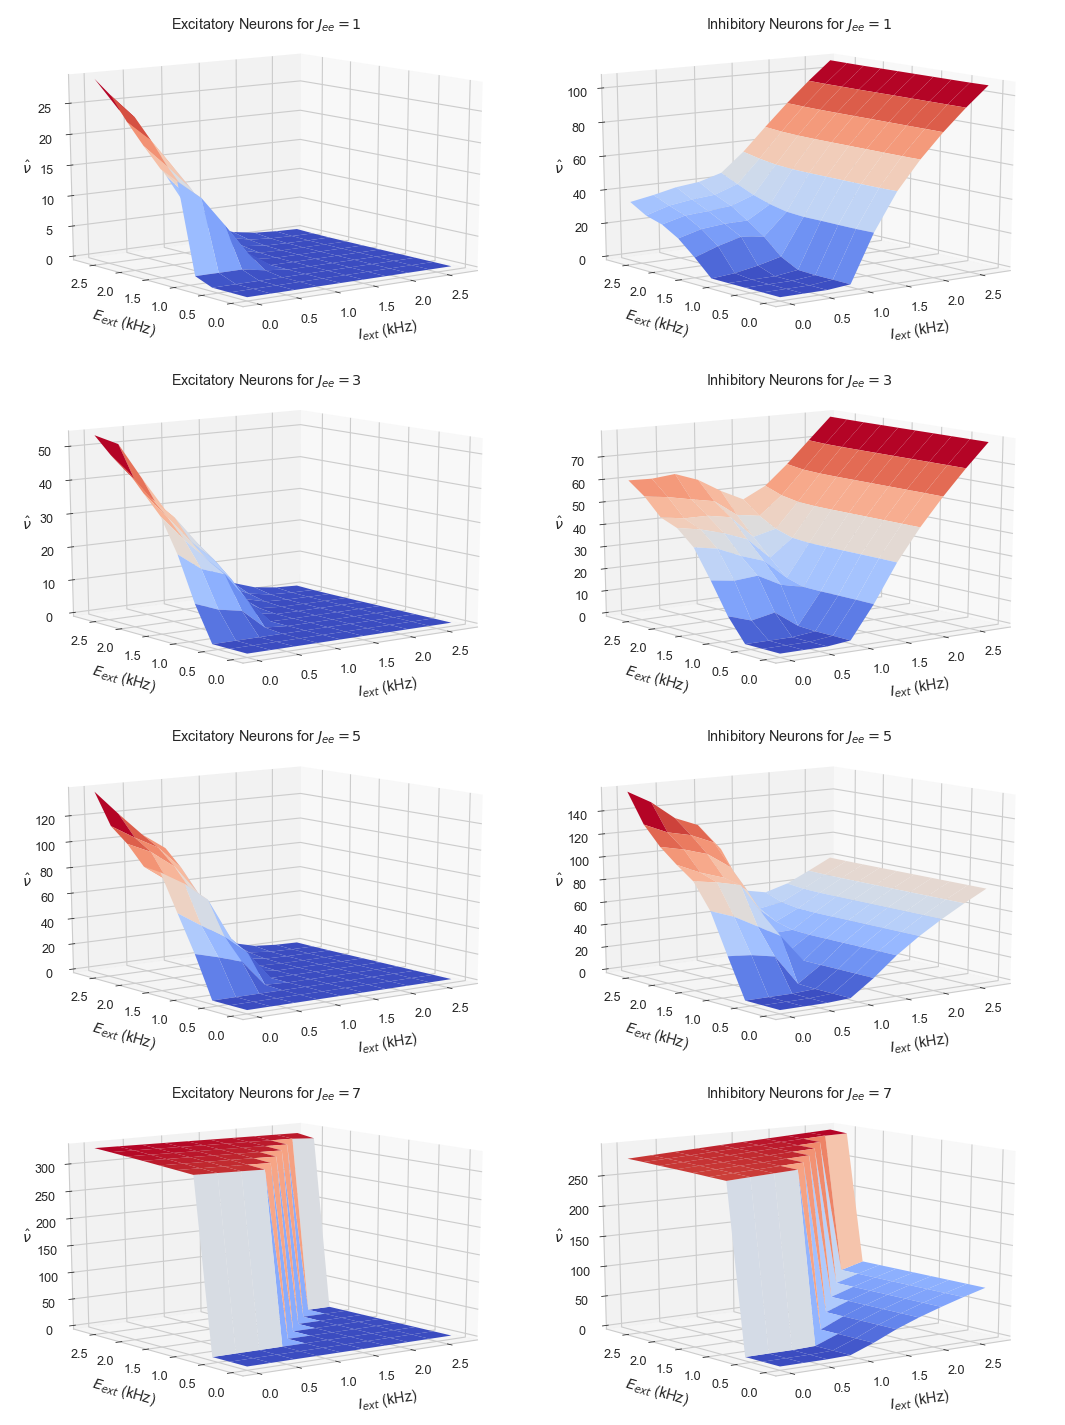

In [14]:
fig = plotting.phase_plane_analysis(folders[0])
phase_plane_file = folders[0]+'/phase_plane.pdf'
fig.savefig(phase_plane_file)

In [15]:
phase_plane_latex_string = figure_template.render(figure=phase_plane_file,
                             caption="Phase Plane.",
                             width=1.0)

r$\nu_{exc, ext} = 1500.0$
r$\nu_{0, inh, ext} = 0.0$
r$\nu_{1, inh, ext} = 300.0$
r$\nu_{2, inh, ext} = 600.0$
r$\nu_{3, inh, ext} = 900.0$
r$\nu_{4, inh, ext} = 1200.0$
r$\nu_{5, inh, ext} = 1500.0$
r$\nu_{7, inh, ext} = 2100.0$


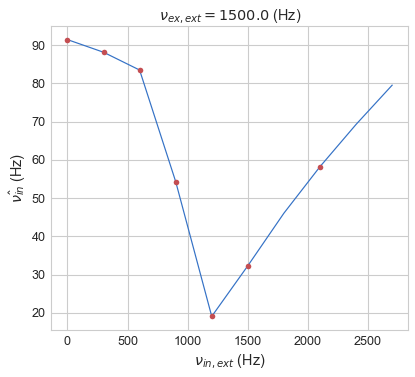

In [16]:
E, I = pickle.load( open(folders[0]+'/E_I.p', 'rb'))
with open(folders[0]+'/e_i_jee_5_0.p', 'rb') as file:
    e, i = pickle.load(file)
    plotting.plot_intersections([0,1,2,3,4,5,7], 5, e, i, E, I, file='intersection.pdf')
    phase_plane_latex_string += figure_template.render(figure='intersection.pdf',
                             caption=r"Intersection for $J_{ee} = 5.0$",
                             width=0.9)

In [17]:
a = np.array([1,2,3])

In [18]:
a.size

3

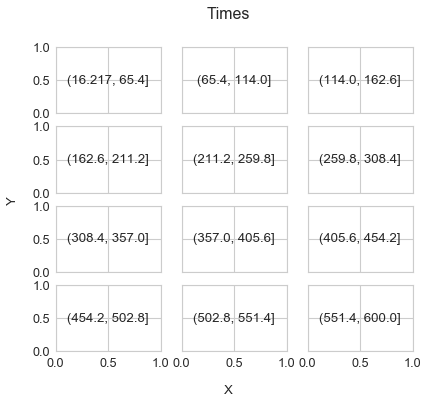

In [21]:
df_ex = pickle.load(open(folders[1]+'/df_ex.pickle', 'rb'))
fig, axes = plotting.visualization_times(df_ex, title='Times')
save_fig_visu_times = folders[0] + '/visu_times.pdf'
fig.savefig(save_fig_visu_times)
visu_latex_string = figure_template.render(figure=save_fig_visu_times,
                             caption=r"Time for Visualisation.",
                             width=1.0) + visu_latex_string

Current Folder: phase_plane_analysis/new_small/e0_15_i0_00
$\hat{\nu_i} = 0.00$


/home/adrossel/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


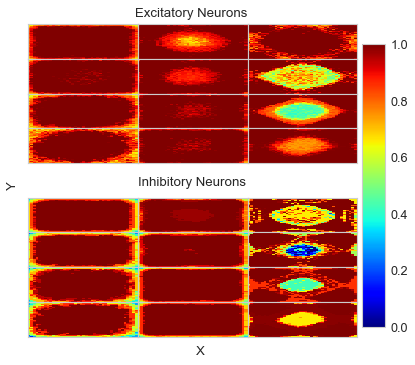

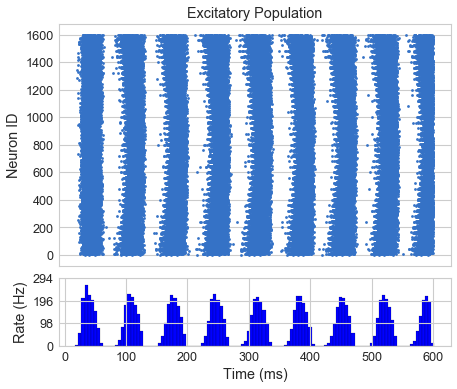

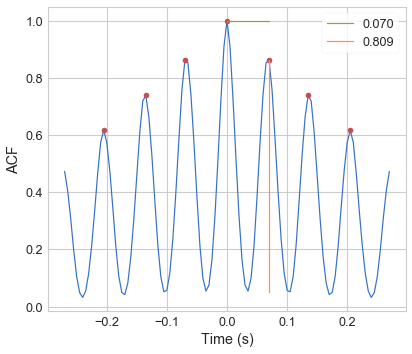

/home/adrossel/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


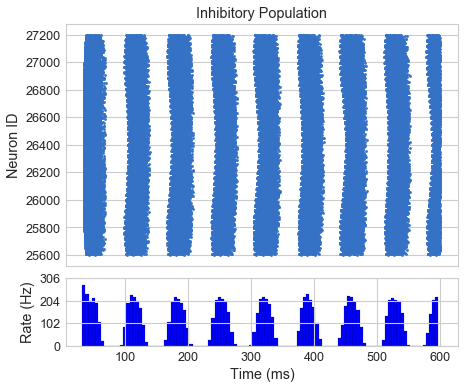

Current Folder: phase_plane_analysis/new_small/e0_15_i0_03
$\hat{\nu_i} = 300.00$


/home/adrossel/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


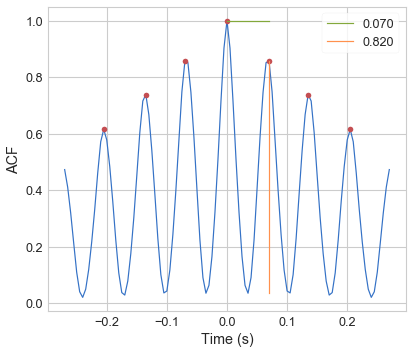

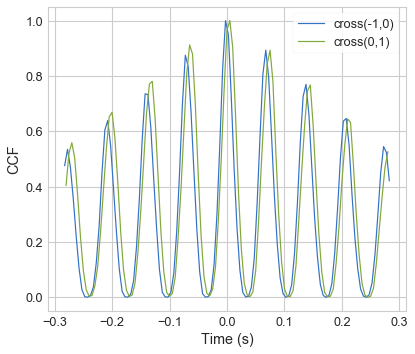

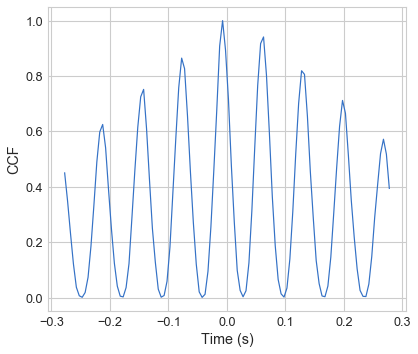

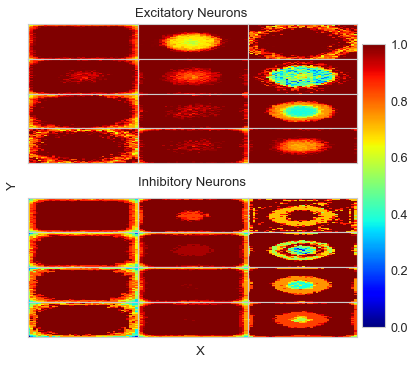

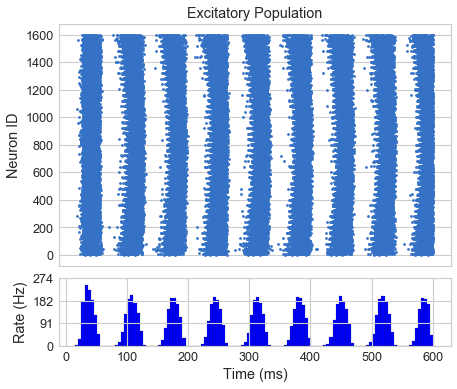

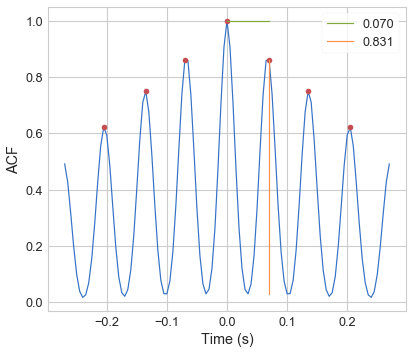

/home/adrossel/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


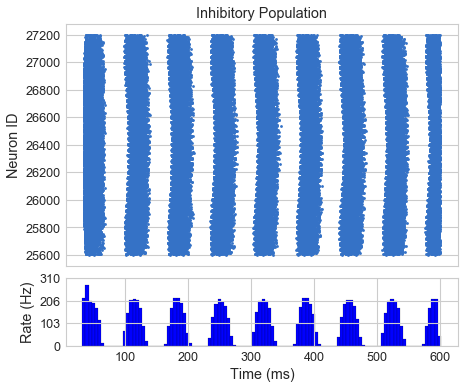

Current Folder: phase_plane_analysis/new_small/e0_15_i0_06
$\hat{\nu_i} = 600.00$


/home/adrossel/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


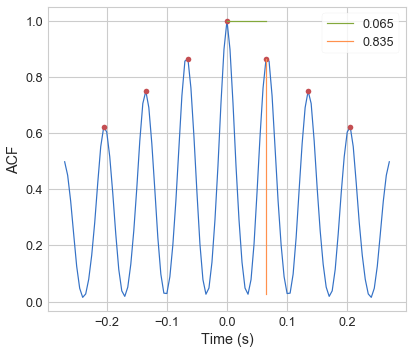

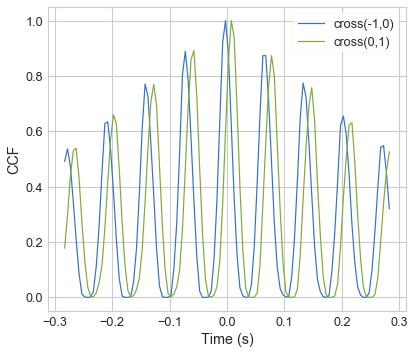

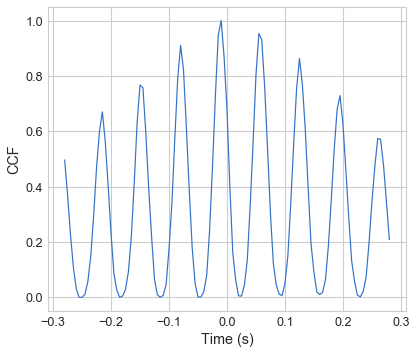

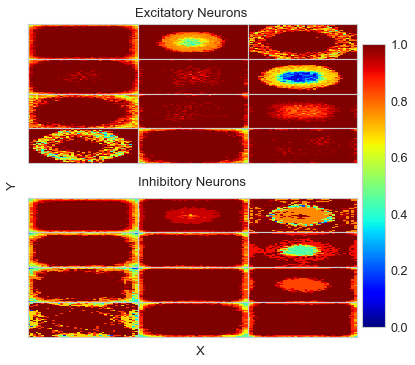

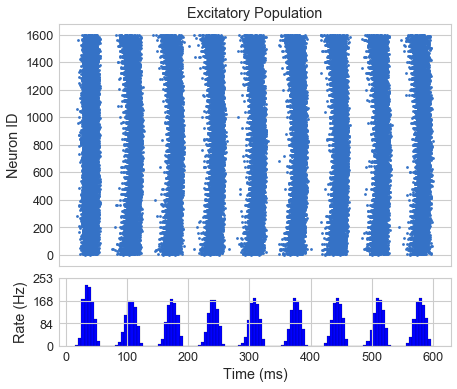

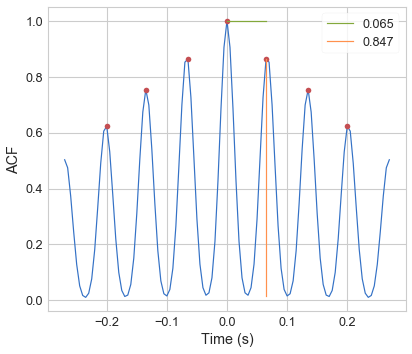

/home/adrossel/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


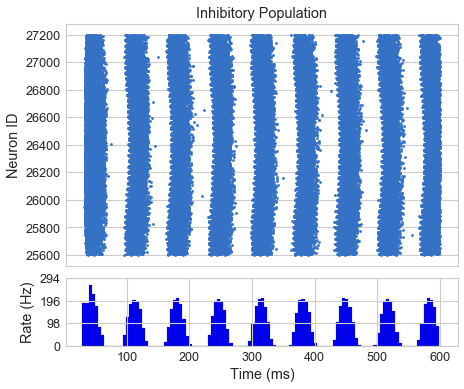

Current Folder: phase_plane_analysis/new_small/e0_15_i0_09
$\hat{\nu_i} = 900.00$


/home/adrossel/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


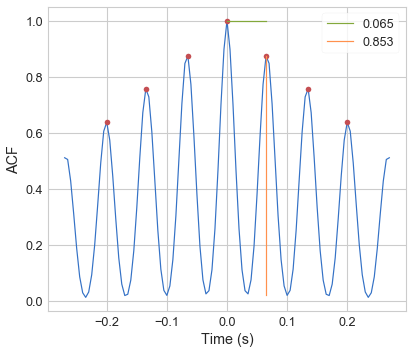

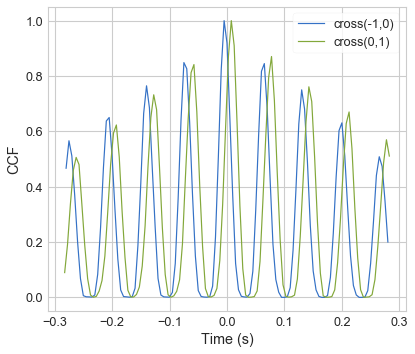

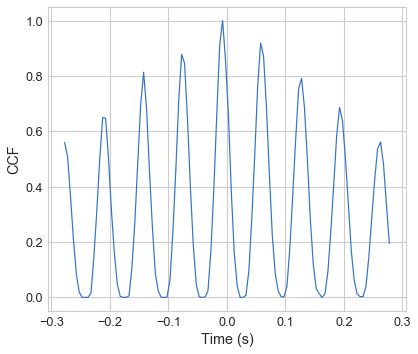

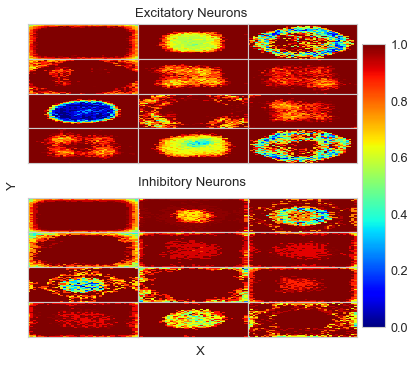

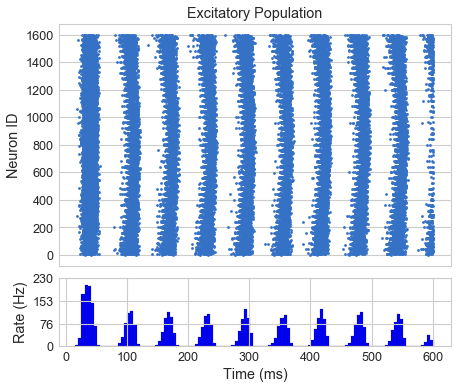

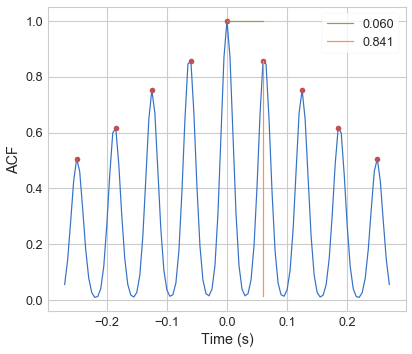

/home/adrossel/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


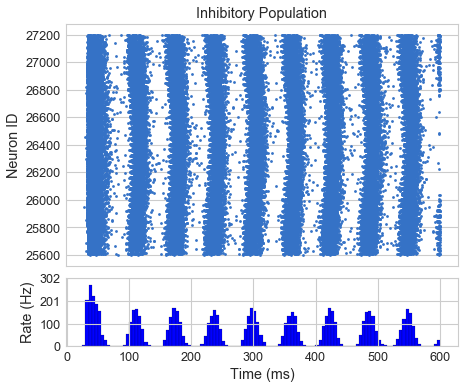

Current Folder: phase_plane_analysis/new_small/e0_15_i0_12
$\hat{\nu_i} = 1200.00$


/home/adrossel/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


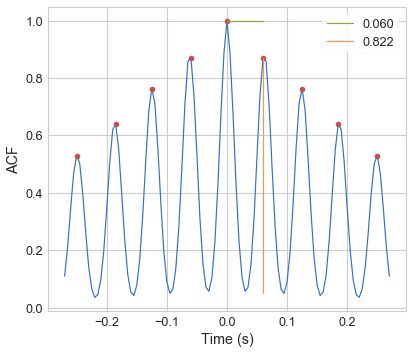

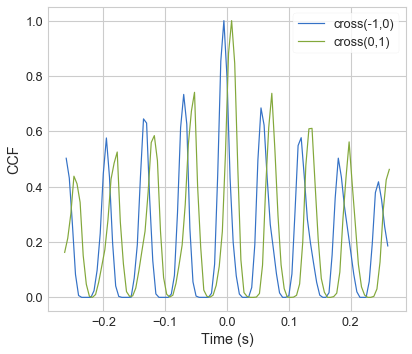

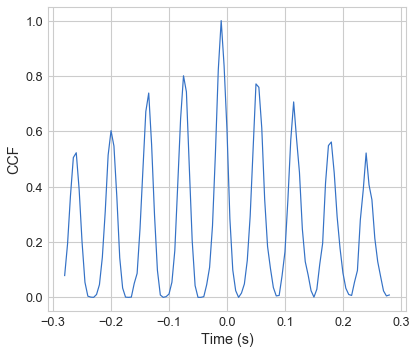

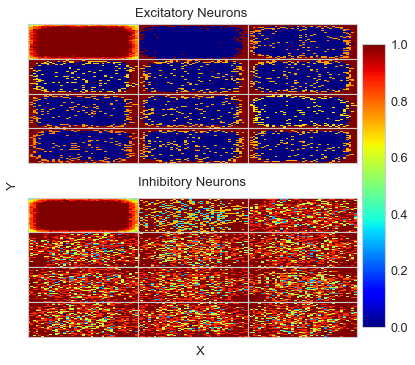

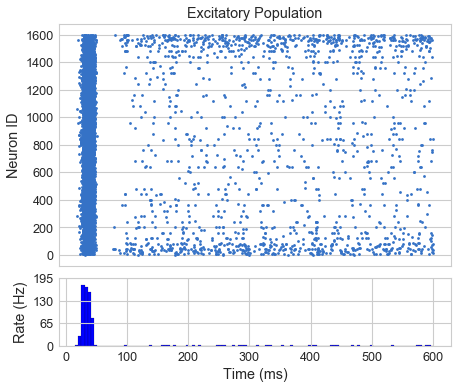

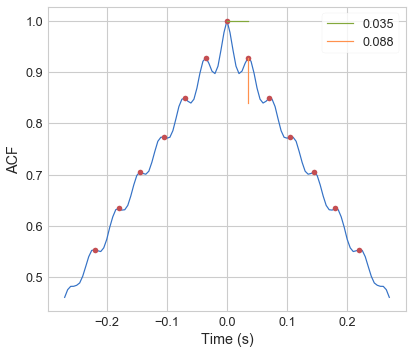

/home/adrossel/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


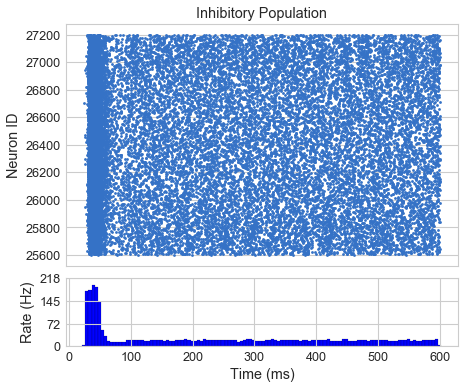

Current Folder: phase_plane_analysis/new_small/e0_15_i0_15
$\hat{\nu_i} = 1500.00$


/home/adrossel/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


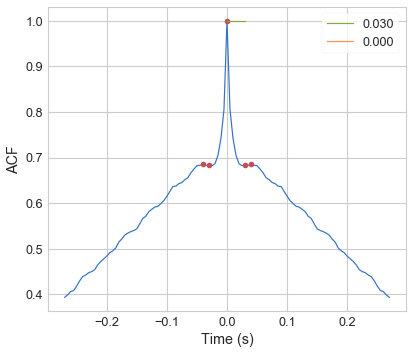

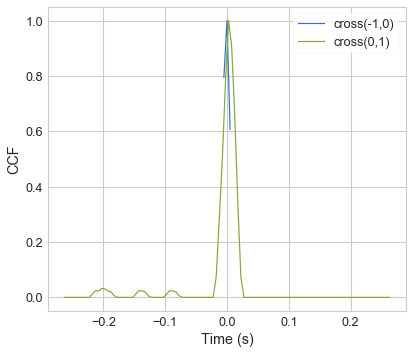

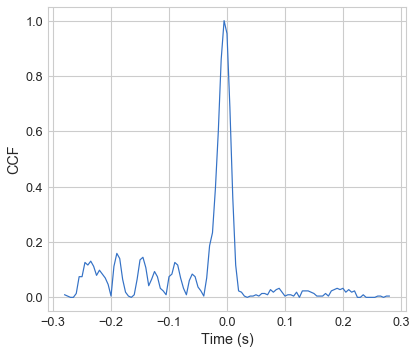

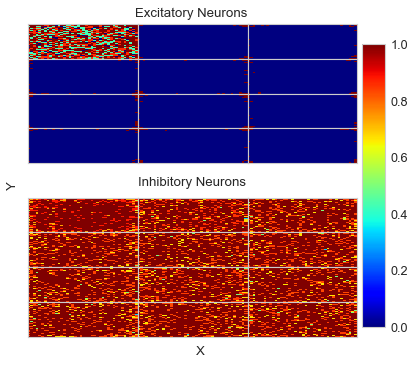

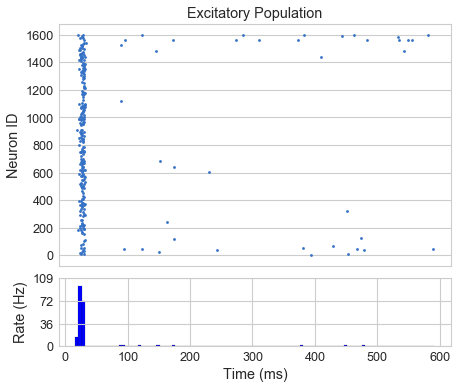

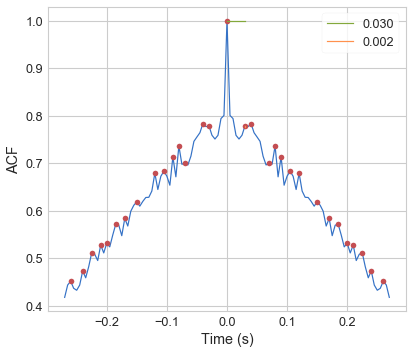

/home/adrossel/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


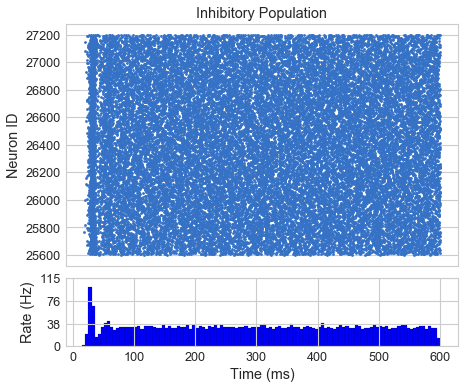

No handles with labels found to put in legend.


ValueError: zero-size array to reduction operation maximum which has no identity

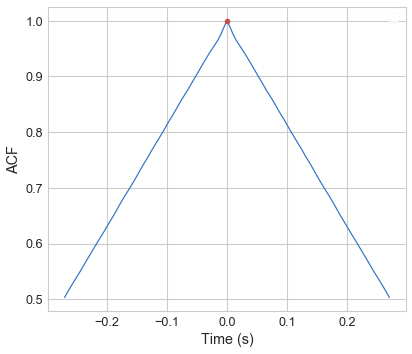

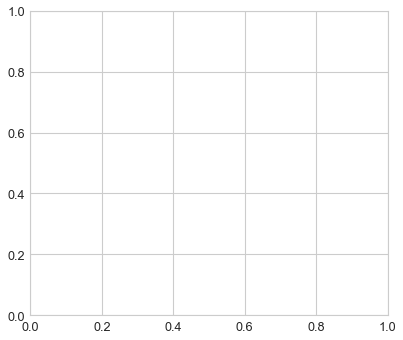

In [20]:
raster_autocorr_latex_string = ""
visu_latex_string = ""
for folder in folders[1:]:
    if not 'stimulus' in folder and not 'periodicity' in folder:
        print("Current Folder: %s" % (folder,))
        para = plotting.getParams(folder, pickle_file='/parameter.pickle')
        print(r'$\hat{\nu_i} = %4.2f$' % (para['Background rate inhibitory'],))
        dynamics_and_raster_plot(folder, save=True, latex=True)

<Figure size 432x288 with 0 Axes>

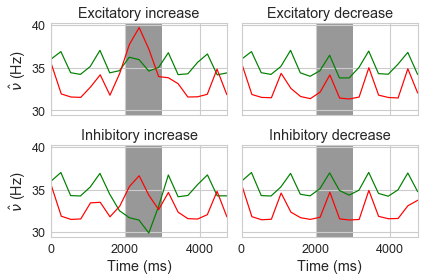

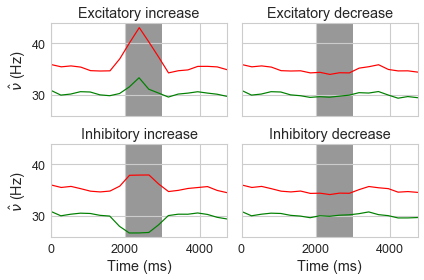

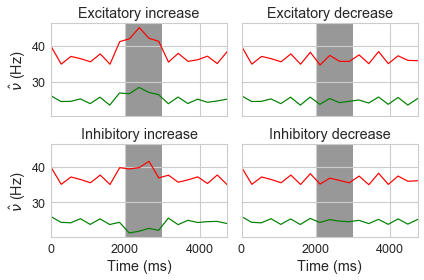

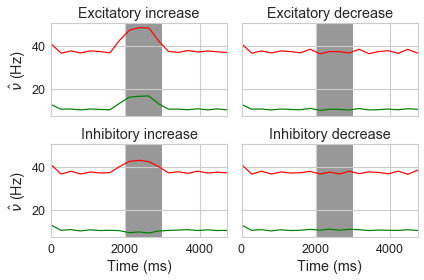

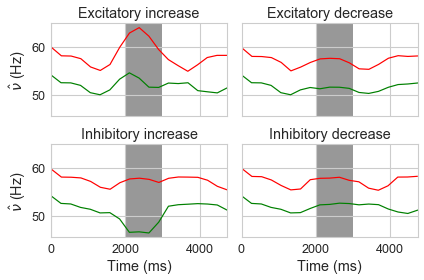

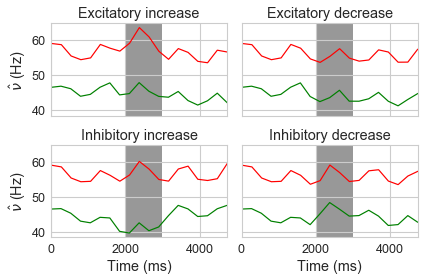

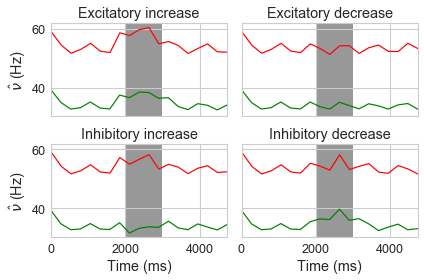

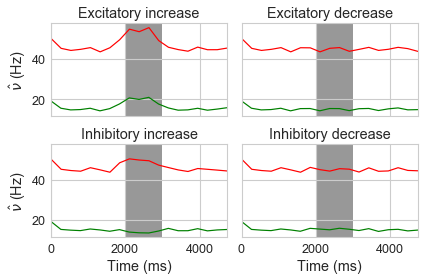

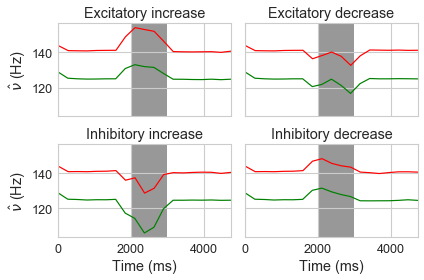

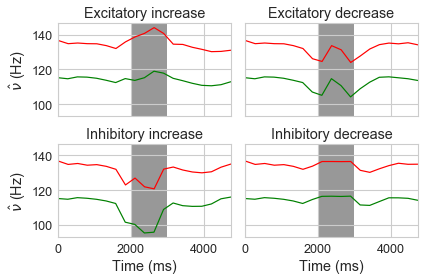

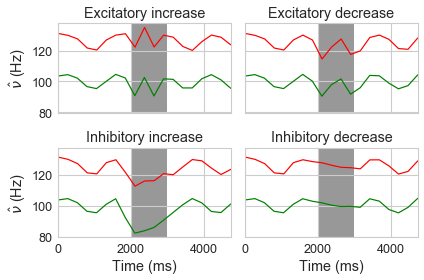

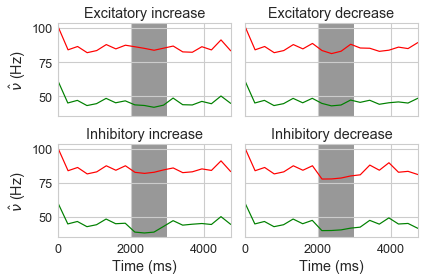

In [29]:
trace_latex_string = ""
path = folders[0]+'/stimulus/'
plt.clf()
fig_dict = {}
for file in files_start_with('exc_', path=path):
    if '-' in file:
        stats = parse_filename(file)
        tmp_file1 = path+file.replace('-','')
        tmp_file2 = path+file
        tmp_file3 = path+file.replace('exc', 'inh').replace('-','')
        tmp_file4 = path+file.replace('exc', 'inh')
        tmp_files = [tmp_file1, tmp_file2, tmp_file3, tmp_file4]
        fig = plotting.trace_plot_all_in_one(tmp_files, title='', 
                                 stim_start=2000., 
                                 stim_end=3000.)
        save_file_at = path+file.replace('exc_', '').replace('-300000', '')+"df"
        fig.savefig(save_file_at)
        trace_latex_string += figure_template.render(
            figure=save_file_at,
            caption=r"""
            Disturbance Test for $J_{ee} = %d$ and $\nu_{inh,ext} = %d \,\si{Hz}$.
            Excitatory population in green and inhibitory population in red. 
            Grey background is the time of increasing or decreasing stimulation 
            in the center of the network.
            """ % (int(stats[1]), int(stats[2])*100, ),
            width=0.9)

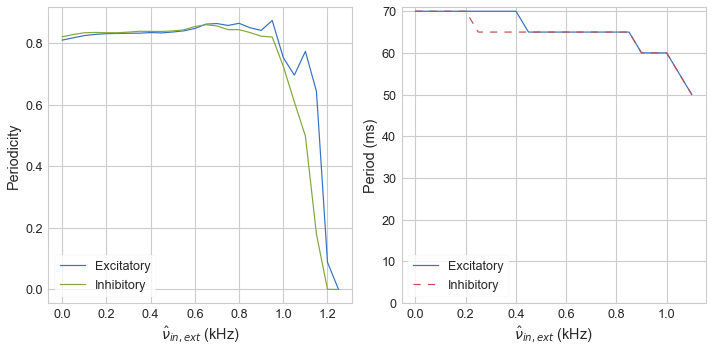

In [290]:
fig = plotting.period_periodicity_plot(folders[0]+'/periodicity/')
tmp = folder[0] + 'periodicity_period.pdf'
fig.savefig(tmp)
raster_autocorr_latex_string += figure_template.render(
            figure=tmp,
            caption=r"""
            Periodicity
            """,
            width=0.9)

In [123]:
with open('figures.tex', 'w') as f:
    f.write(latex_header)
    f.write(phase_plane_latex_string.replace('{ ','{').replace(' }','}'))
    f.write(r'\clearpage')
    f.write(visu_latex_string.replace('{ ','{').replace(' }','}'))
    f.write(r'\clearpage')
    f.write(raster_autocorr_latex_string.replace('{ ','{').replace(' }','}'))
    f.write(r'\clearpage')
    f.write(trace_latex_string.replace('{ ','{').replace(' }','}'))
    f.write(latex_footer)